# Weighted K-Means clustering for the Boundery Layer Case

As seen in the ```K_Means_BL``` notebook, due to K-Means clustering relying solely on the euclidean distance between points and their distribution in the equation space, using it meant relying on a using a large cluster number.

Here, a weighted K-Means algorithm is used, where weights are defined as a function of the points' distance from the origin.

Again, the preprocessing carried out is the same:

In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import sys
from sklearn.cluster import KMeans
from sklearn.decomposition import SparsePCA
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from joblib import Parallel, delayed

# adding Tools to the system path
sys.path.insert(0, "../Tools/")
import plot_funcs as pf
import preprocessing as pp

# 1. Preprocessing

## a. Load the data

In [2]:
# Load the data from http://turbulence.pha.jhu.edu/Transition_bl.aspx
file = h5py.File("../Data/Transition_BL_Time_Averaged_Profiles.h5", "r")

In [3]:
# Get arrays for variables and the Reynold's averages
x = np.array(file["x_coor"])
y = np.array(file["y_coor"])
u_bar = np.array(file["um"])
v_bar = np.array(file["vm"])
p_bar = np.array(file["pm"])
R_uu = np.array(file["uum"]) - u_bar**2
R_uv = np.array(file["uvm"]) - u_bar * v_bar
R_vv = np.array(file["uvm"]) - v_bar**2

In [4]:
# Visualize by wall-normal Reynolds stress
X, Y = np.meshgrid(x, y)

# Include line of 99% of free flow mean velocity
# Values from http://turbulence.pha.jhu.edu/docs/README-transition_bl.pdf
U_inf = 1
nu = 1 / 800
Re = (U_inf / nu) * x

## b. Get the finite difference derivatives to estimate the gradients

__NOTE: VARIABLE STEP SIZE IN Y DIRECTION ONLY__

In [5]:
# Get space steps
dx = x[1] - x[0]
# Get y space steps:
# The y step is not constant, so we need to calculate it for each point
dy = np.diff(y[::-1])
dy = np.append(dy, dy[-1])

nx = len(x)  # Number of points in x
ny = len(y)  # Number of points in y

In [6]:
# Get the gradients
u_x, u_y, lap_u, v_y, p_x, R_uux, R_uvy = pp.get_derivatives_numpy(
    nx, ny, dx, y, u_bar, v_bar, p_bar, R_uu, R_uv
)

# Flatten arrays using fortran ordering
u_bar = u_bar.flatten("F")
v_bar = v_bar.flatten("F")
p_bar = p_bar.flatten("F")
R_uu = R_uu.flatten("F")
R_uv = R_uv.flatten("F")

# Flatten the derivative terms arrays for the rest of the notebook
lap_u = lap_u.flatten("F")
R_uux = R_uux.flatten("F")
R_uvy = R_uvy.flatten("F")
u_x = u_x.flatten("F")
u_y = u_y.flatten("F")
v_y = v_y.flatten("F")
p_x = p_x.flatten("F")

## c. Equation space representation

In [7]:
# Labels of terms in the RANS equation
labels = [
    r"$\bar{u} \bar{u}_x$",
    r"$\bar{v}\bar{u}_y$",
    r"$\rho^{-1} \bar{p}_x$",
    r"$\nu \nabla^2 \bar{u}$",
    r"$\overline{(u^\prime v^\prime)}_y$",
    r"$\overline{({u^\prime} ^2)}_x$",
]

In [8]:
# Get terms stored as features
features = 1e3 * np.vstack([u_bar * u_x, v_bar * u_y, p_x, nu * lap_u, R_uvy, R_uux]).T
nfeatures = features.shape[1]

# 2. Weighted K-Means 

Now, the weighted K-Means model is trained on a subset of the data with weights applied. The weights are defined as a function of the point's distance from the origin, and using the tanh() function:

$w = 1 - (\text{tanh}^{2}(\frac{1}{2}|\vec{OX}|))$

where $|\vec{OX}|$ is the point-origin distance.

These weights are between 0 and 1, and give more importance to points closer to the origin (e.g. plot below). This is so that the K-Means algorithm is encouraged to cluster points near the origin into separate groups.

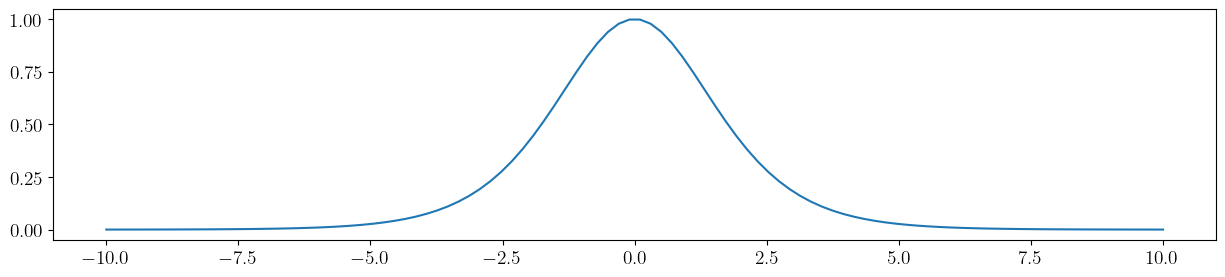

In [9]:
ox = np.linspace(-10, 10, 100)
plt.plot(ox, 1 - (np.tanh((1 / 2) * ox)) ** 2)
plt.show()

## a. Train the model and predict for full dataset

In [10]:
# Train K-means model

# Fit weighted K-means model
nc = 6  # Number of clusters
seed = 75016  #  Set a seed for debugging/plotting
np.random.seed(seed)

# Initialize the K-means model
model = KMeans(n_clusters=nc, n_init=10, random_state=seed)

# Train on only a subset (20%) of the data
sample_pct = 0.2
mask = np.random.permutation(features.shape[0])[: int(sample_pct * features.shape[0])]

In [11]:
# Set tanh sample weights
origin_dist_mask = np.linalg.norm(features[mask, :], axis=1)
sample_weights_mask = 1 - (np.tanh((1) * origin_dist_mask)) ** 2

# Fit the model
model.fit(features[mask, :], sample_weight=sample_weights_mask)

KMeans(n_clusters=6, n_init=10, random_state=75016)

In [12]:
# Predict clusters for all data
origin_dist = np.linalg.norm(features, axis=1)
sample_weights = 1 - (np.tanh((1) * origin_dist)) ** 2

# Predict clusters
clustering = model.predict(features, sample_weight=sample_weights)

# Get covariances in each cluster
covs = np.zeros((nc, nfeatures, nfeatures))
for i in range(nc):
    mask_ = clustering == i
    covs[i, :, :] = np.cov(features[mask_, :].T)

/Users/thomasbreitburd/anaconda3/envs/Project_24/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1102: FutureWarning: 'sample_weight' was deprecated in version 1.3 and will be removed in 1.5.
  warnings.warn(


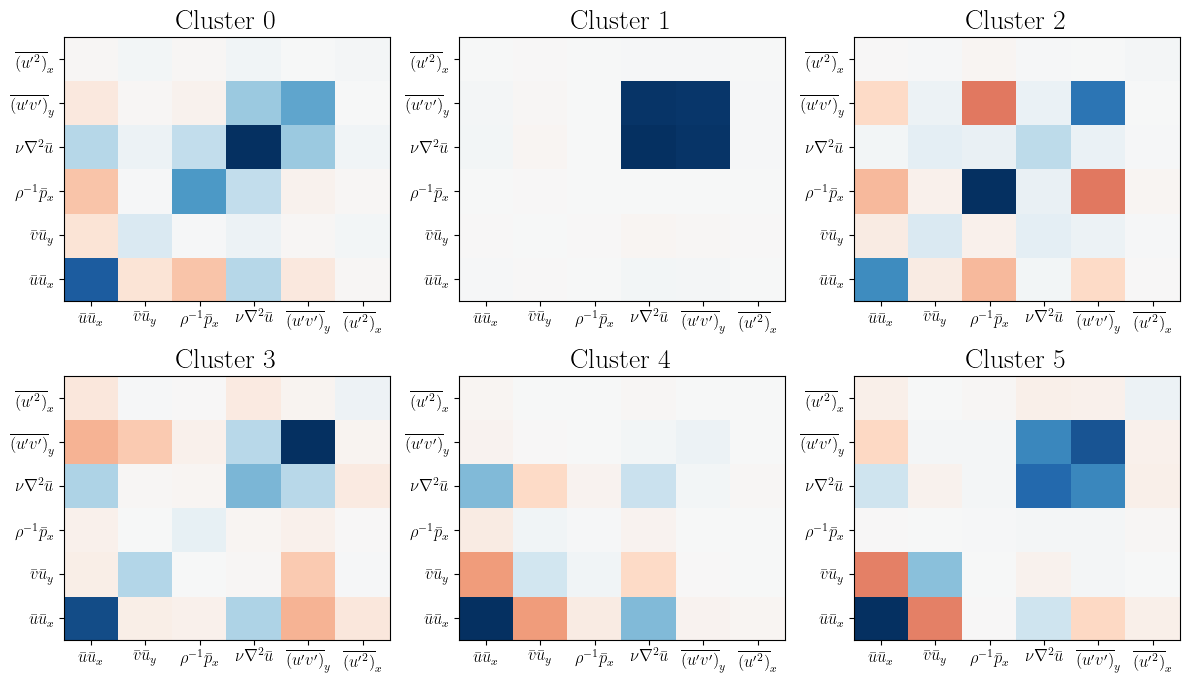

In [13]:
# Plot covariance matrices for each GMM cluster
pf.plot_cov_mat(covs, nfeatures, nc, labels, "Other", f"BL/WKMeans_CovMat_{nc}.png")

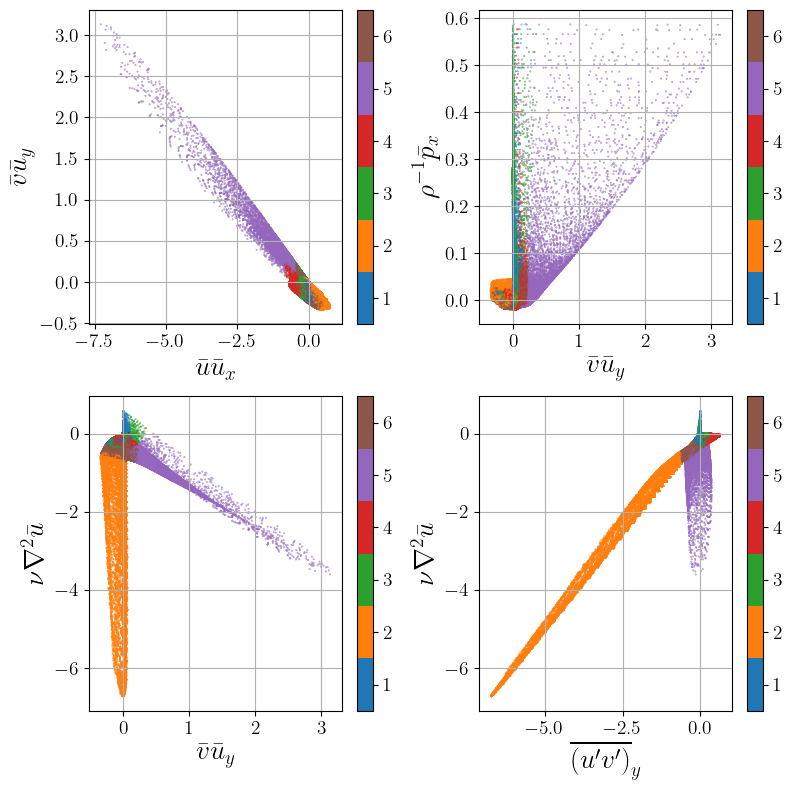

In [14]:
# Visualize the weighted k-means clustering with 2D views of equation space
cluster_idx = clustering + 1

pf.plot_clustering_2d_eq_space(
    features[mask, :], cluster_idx[mask], nc, f"BL/WKMeans_2D_eq_space_{nc}.png"
)

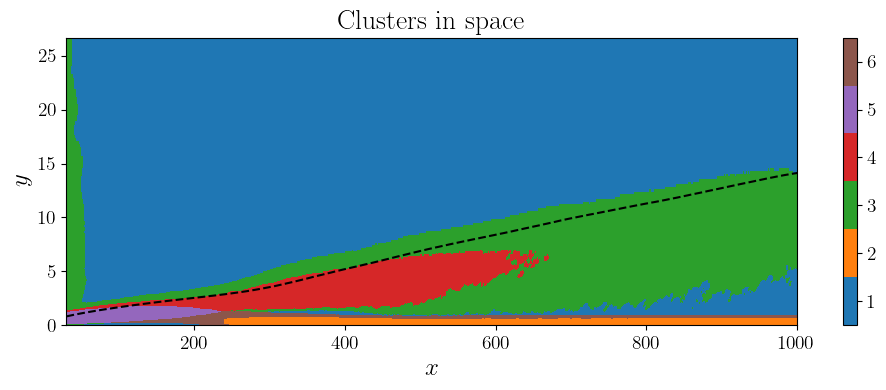

In [15]:
# Assign points in space to each cluster
cluster_idx = clustering
clustermap = np.reshape(cluster_idx, [ny, nx], order="F")

# Visualize the clustering in space
pf.plot_clustering_space(
    clustermap,
    x,
    y,
    X,
    Y,
    nx,
    ny,
    nc,
    u_bar,
    U_inf,
    f"BL/WKMeans_clustering_space_{nc}.png",
)

## b. Sparce Principal Component Analysis (SPCA) dimensionality reduction

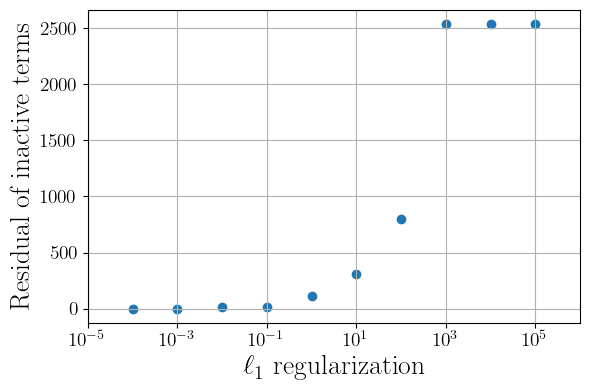

In [16]:
# Sparse PCA to identify directions of nonzero variance in each cluster

alphas = [1e-4, 1e-3, 1e-2, 0.1, 1, 10, 100, 1e3, 1e4, 1e5]
err = np.zeros([len(alphas)])


def spca_err(alpha, cluster_idx, features, nc):
    err_ = 0

    for i in range(nc):
        # Identify points in the field corresponding to each cluster
        feature_idx = np.where(cluster_idx == i)[0]
        cluster_features = features[feature_idx, :]

        # Conduct Sparse PCA
        spca = SparsePCA(n_components=1, alpha=alpha)
        spca.fit(cluster_features)

        # Identify inactive terms
        inactive_terms = np.where(spca.components_[0] == 0)[0]

        # Calculate error as the l2 norm of the inactive terms
        err_ += np.sqrt(np.sum((cluster_features[:, inactive_terms].ravel()) ** 2))

    return err_


err = Parallel(n_jobs=4)(
    delayed(spca_err)(alpha, cluster_idx, features, nc) for alpha in alphas
)

pf.plot_spca_residuals(alphas, err, f"BL/WKMeans_spca_residuals_{nc}.png")

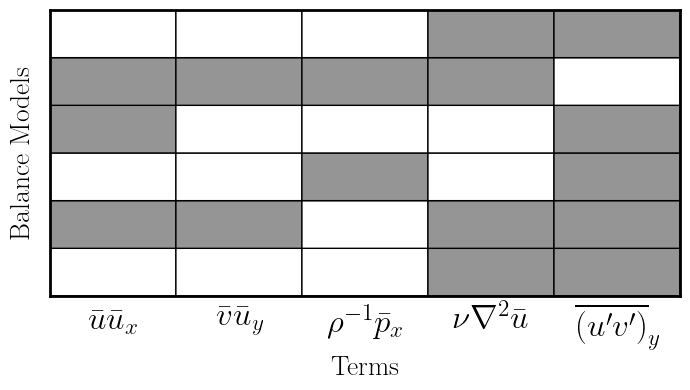

In [17]:
# Get the active terms for each cluster for optimal alpha

alpha_opt = 7  # Optimal alpha value

spca_model = np.zeros([nc, nfeatures])  # Store the active terms for each cluster

for i in range(nc):
    # Identify points in the field corresponding to each cluster
    feature_idx = np.nonzero(cluster_idx == i)[0]
    cluster_features = features[feature_idx, :]

    # Conduct Sparse PCA
    spca = SparsePCA(
        n_components=1, alpha=alpha_opt, random_state=seed
    )  # normalize_components=True
    spca.fit(cluster_features)

    # Identify active terms
    active_terms = np.nonzero(spca.components_[0])[0]
    if len(active_terms) > 0:
        spca_model[i, active_terms] = 1  # Set the active terms to 1

# Plot the active terms in each cluster
pf.plot_balance_models(
    spca_model, labels, False, f"BL/WKMeans_active_terms_{nc}_{alpha_opt}.png"
)

## c. Resulting Final Dominant Balance Models

In [18]:
# Identify clusters with identical balance models
balance_models, model_index = np.unique(spca_model, axis=0, return_inverse=True)
nmodels = balance_models.shape[0]

# Make new cluster_idx based on the unique SPCA balance model
balance_idx = np.array([model_index[i] for i in cluster_idx])
balancemap = np.reshape(balance_idx, [ny, nx], order="F")

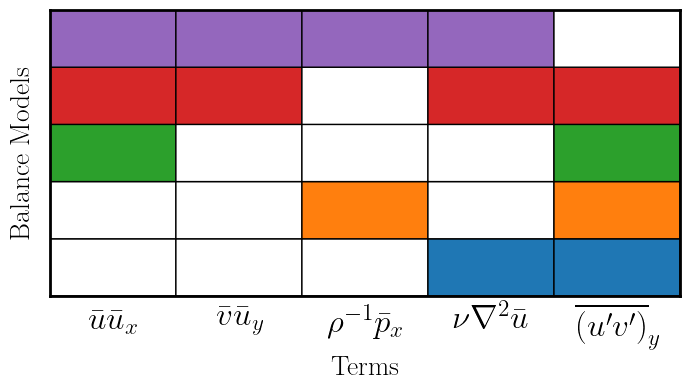

In [19]:
# Plot the final balance models
pf.plot_balance_models(
    balance_models, labels, True, f"BL/WKMeans_balance_models_{nc}_{alpha_opt}.png"
)

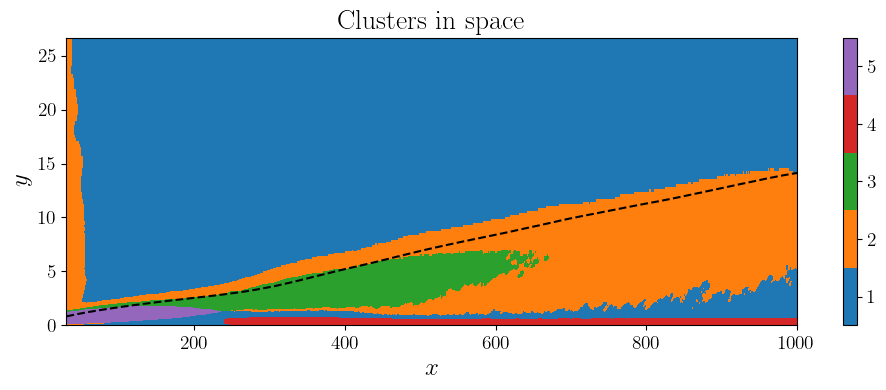

In [20]:
# Visualize the clustering in space
pf.plot_clustering_space(
    balancemap,
    x,
    y,
    X,
    Y,
    nx,
    ny,
    nmodels,
    u_bar,
    U_inf,
    f"BL/WKMeans_spca_clustering_space_{nc}_{alpha_opt}.png",
)

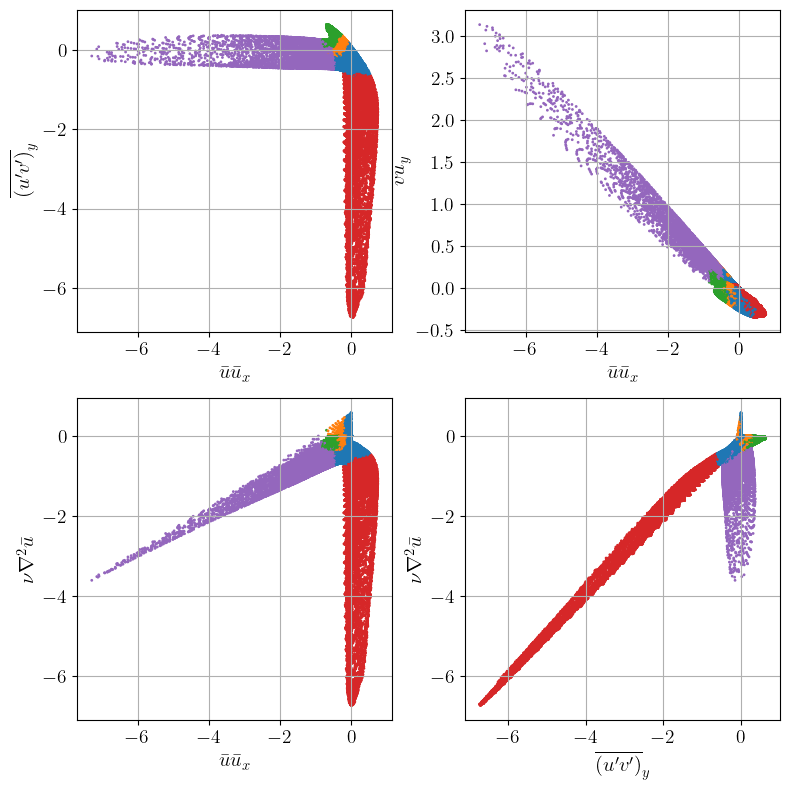

In [21]:
# 2D views of feature space
pf.plot_feature_space(
    features[mask, :],
    balance_idx[mask],
    f"BL/WKMeans_feature_space_{nc}_{alpha_opt}.png",
)

The weighted K-means algorithm does in fact lead a better discernment of the different dominant balance regimes but with a few inconsistencies. First, regions that probably would not have the same dynamics are clustered together. Taking the 1st (blue) cluster, which has active terms that match the visocus sublayer, it groups together the free-flow and the viscous sublayer under the same dominant balance model, even though the dominant balance model of the viscous sublayer is identified but for a thinner layer above the red cluster, which does not have the active terms that would correspond to the viscous sublayer. Additionally part of the laminar inflow region is identified as a separate cluster (purple), however applying SPCA to that cluster returns all terms except $\bar{(u'^{2})_{x}}$ as active, unlike in the validated GMM case.

## Outer Layer Scaling

The length scale of the outer layer should scale with $ \ell \sim x^{4/5} $ (see pg 71 in Holmes, Lumley, Berkooz or pg 638 in Schlichting)

As a rough diagnostic of our balance model, define the outer layer length scale as the wall-normal coordinate where the balance changes from the inertial sublayer to the free-stream (once the transitional region has disappeared).

In [22]:
print(np.array(balance_models))
print(np.where(np.all(balance_models == [1.0, 0.0, 0.0, 0.0, 1.0, 0.0], axis=1))[0])

[[0. 0. 0. 1. 1. 0.]
 [0. 0. 1. 0. 1. 0.]
 [1. 0. 0. 0. 1. 0.]
 [1. 1. 0. 1. 1. 0.]
 [1. 1. 1. 1. 0. 0.]]
[2]


[0.0583548  0.80138047]


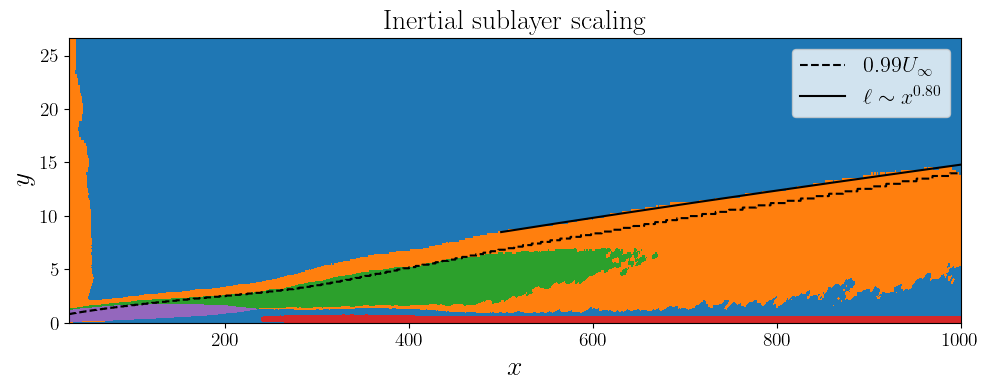

In [23]:
# Create a u_bar field:
u_map = np.reshape(u_bar, (ny, nx), order="F")

# Find which cluster is the inertial sublayer.
inert_sub_idx = 0

# Define some variables
x_min = 110  # Where inertial balance begins
x_turb = 500  # Where transitional region ends

x_idx = np.nonzero(x > x_min)[0]
x_layer = x[x_idx]

# First, find the upper extent of the inertial sublayer
y_gmm = np.zeros(len(x_idx))
# Loop through wall-normal direction until the balance changes
for i in range(len(x_idx)):
    j = len(y) - 1
    while balancemap[j, x_idx[i]] == inert_sub_idx:
        j -= 1
    y_gmm[i] = y[j]  # Store upper value of inertial balance

# Next, find the 99% of free stream velocity line
delta = np.zeros(len(x))
# Loop until velocity falls past 99% freestream
for i in range(len(x)):
    j = 0
    while u_map[j, i] < 0.99:
        j += 1
    delta[i] = y[j - 1]

# Fit inertial balance to power law
power_law = lambda x, a, b: a * x**b

x_to_fit = x_layer > x_turb  # End of transitional region
p_gmm, cov = curve_fit(power_law, x_layer[x_to_fit], y_gmm[x_to_fit])
gmm_fit = power_law(x_layer, *p_gmm)
print(p_gmm)

# Plot the inertial sublayer scaling
pf.plot_sublayer_scaling(
    x,
    y,
    balancemap,
    delta,
    x_layer,
    gmm_fit,
    p_gmm,
    x_to_fit,
    f"BL/WKMeans_sublayer_scaling_{nc}_{alpha_opt}.png",
)

## Self-similarity

In the near-wall region (viscous sublayer), we should be able to collapse the profiles using wall units $u^+$, $y^+$. These wall units are defined as: 
- $y^{+}=\frac{y u_{\tau}}{\nu}$, the distance $y$ to the wall, dimensionaless using friction velocity $u_{\tau}$, and kinematic viscosity $\nu$.
- $u^{+}=\frac{u}{u_{\tau}}$, the dimensonless velocity as a function of y.

Here we show that this universality breaks down at approximately the same place where the identified viscous sublayer balance ends. Therefore demonstrating the identified balance models follow fluid dynamics theory.

As shown in the figure above, the wall-normal extent of the sublayer (red) is approximately constant in the fully-developed turbulent region. We show below that this corresponds to $y^+ \sim 40$.

[Wikipedia](https://en.wikipedia.org/wiki/Law_of_the_wall)

24.974760963085185
24.299237368661192
24.533143469757086
24.06131984202461
23.68333342427192


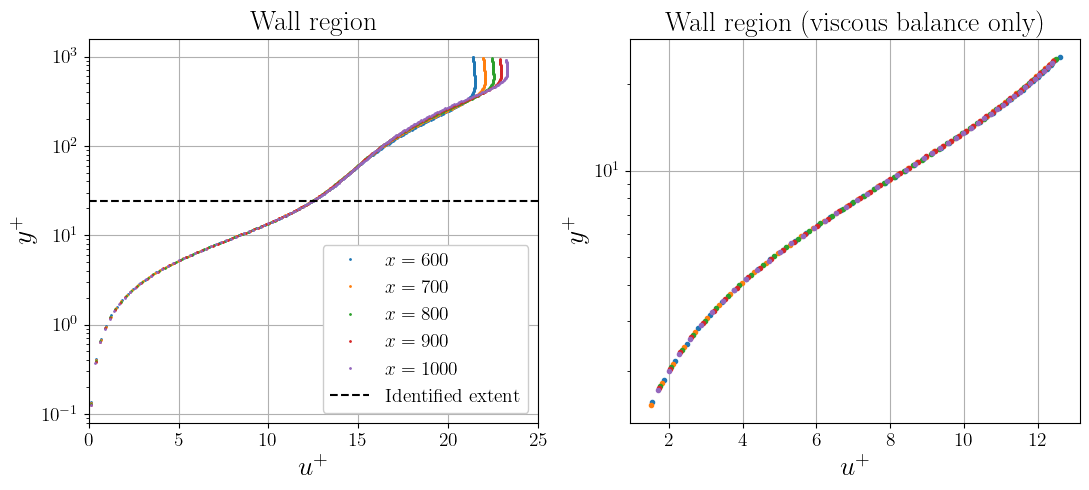

In [24]:
# Compute friction velocity with an estimate of the wall shear stress
u_tau = np.sqrt(nu * u_y[::ny])

# Define wall units
y_plus = np.outer(y, u_tau / nu)
u_plus = np.reshape(u_bar, [ny, nx], order="F") / u_tau

# Plot the self-similarity of the flow
pf.plot_self_similarity(
    x, 3, y_plus, u_plus, balancemap, f"BL/WKMeans_self_similarity_{nc}_{alpha_opt}.png"
)

## Blasius solution in laminar regime

We also find that there is an inflow region without significant Reynolds stress (purple), which suggests this flow is approximately laminar, until the transitional (green) region begins around $x\sim 100$.  Before that we would expect the Blasius boundary layer solution to hold.

__Blasius solution:__
$$ \eta = y \sqrt{\frac{U}{2\nu x} }$$
$$ u = U f'(\eta) $$
[Wikipedia](https://en.wikipedia.org/wiki/Blasius_boundary_layer#Blasius_equation_-_first-order_boundary_layer)

Then we can compare the inflow profile to the Blasius solution (dotted lines indicate region where the transitional balance begins, after $x \sim 150$.  Until that point there is a maximum deviation of about 6% from the Blasius solution.